In [ ]:

# =====================================
# 1. SETUP AND INSTALLATIONS
# =====================================

!pip install imbalanced-learn xgboost lightgbm shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

import xgboost as xgb
import lightgbm as lgb
import shap

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

# =====================================

All libraries imported successfully!


In [ ]:
# =====================================
# 2. DATA LOADING AND INITIAL EXPLORATION
# =====================================

# Load the datasets
# Replace these paths with your actual file paths
train_path = "/content/train_dataset_final1.csv"  # Update with your train dataset path
validation_path = "/content/validate_dataset_final.csv"  # Update with your validation dataset path

# Load training data
train_df = pd.read_csv(train_path)
print(f"Training dataset shape: {train_df.shape}")

# Load validation data
validation_df = pd.read_csv(validation_path)
print(f"Validation dataset shape: {validation_df.shape}")

# Basic info about the dataset
print("\n=== DATASET OVERVIEW ===")
print(train_df.info())
print("\n=== FIRST FEW ROWS ===")
print(train_df.head())

print("\n=== TARGET VARIABLE DISTRIBUTION ===")
print(train_df['next_month_default'].value_counts())
print(f"Default rate: {train_df['next_month_default'].mean():.3f}")

# =====================================


Training dataset shape: (25247, 27)
Validation dataset shape: (5016, 26)

=== DATASET OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bil


=== PERFORMING EXPLORATORY DATA ANALYSIS ===


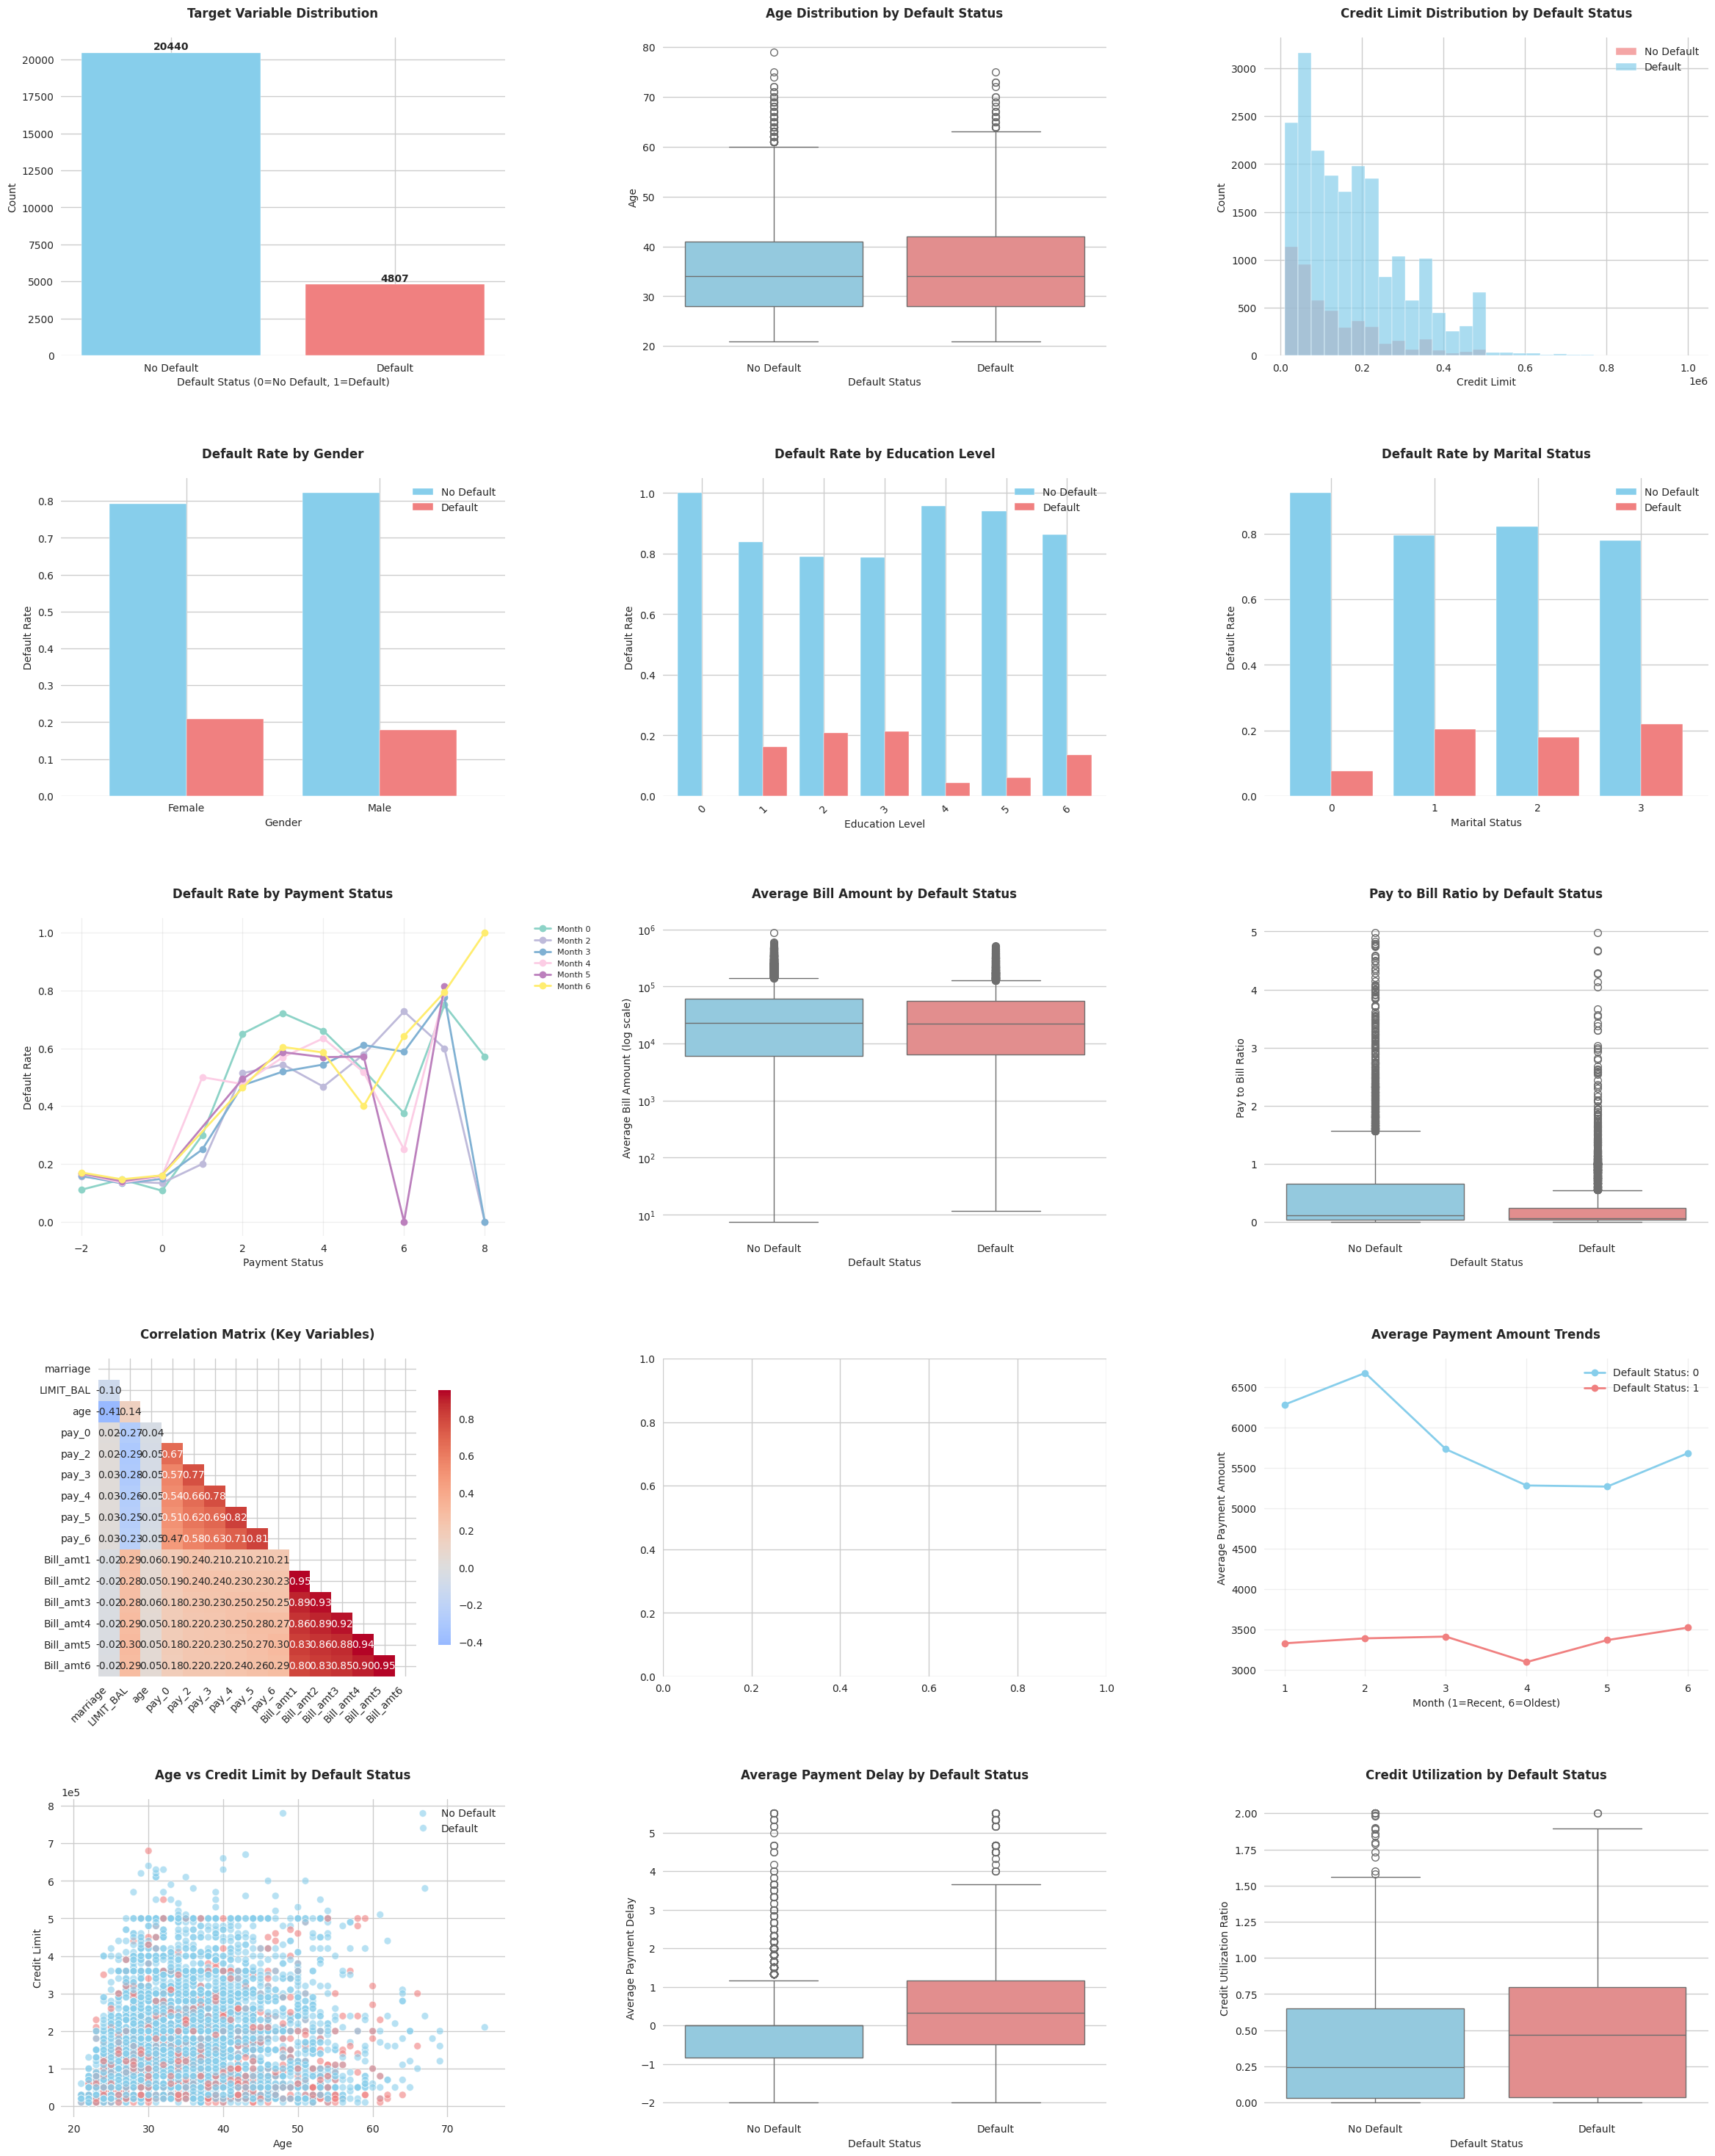


=== FINANCIAL INSIGHTS ===
Default rate by Gender:
        count    mean     std
Female   9995  0.2086  0.4063
Male    15252  0.1785  0.3829

Default rate by Education:
           count    mean     std
education                       
0             14  0.0000  0.0000
1           8988  0.1618  0.3683
2          11717  0.2091  0.4067
3           4115  0.2131  0.4096
4            116  0.0431  0.2040
5            253  0.0593  0.2366
6             44  0.1364  0.3471

Default rate by Marriage:
          count    mean     std
marriage                       
0            53  0.0755  0.2667
1         11480  0.2037  0.4028
2         13441  0.1789  0.3832
3           273  0.2198  0.4149

Credit Limit Statistics by Default Status:
              count       mean        std      min      25%       50%  \
No Default  20440.0  177539.24  131640.12  10000.0  60000.0  150000.0   
Default      4807.0  129234.45  114204.61  10000.0  50000.0   90000.0   

                 75%        max  
No Default  2500

In [ ]:
# =====================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# =====================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set matplotlib backend and style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

def create_eda_plots(df):
    """Comprehensive EDA function"""

    # Set up the plotting area with better spacing
    fig = plt.figure(figsize=(24, 30))
    fig.patch.set_facecolor('white')

    # 1. Target variable distribution
    plt.subplot(5, 3, 1)
    target_counts = df['next_month_default'].value_counts()
    bars = plt.bar(target_counts.index, target_counts.values, color=['skyblue', 'lightcoral'])
    plt.title('Target Variable Distribution', fontsize=12, fontweight='bold', pad=20)
    plt.xlabel('Default Status (0=No Default, 1=Default)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks([0, 1], ['No Default', 'Default'])
    # Add value labels on bars
    for bar, value in zip(bars, target_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                str(value), ha='center', va='bottom', fontweight='bold')

    # 2. Age distribution by default status
    plt.subplot(5, 3, 2)
    sns.boxplot(data=df, x='next_month_default', y='age', palette=['skyblue', 'lightcoral'])
    plt.title('Age Distribution by Default Status', fontsize=12, fontweight='bold', pad=20)
    plt.xlabel('Default Status', fontsize=10)
    plt.ylabel('Age', fontsize=10)
    plt.xticks([0, 1], ['No Default', 'Default'])

    # 3. Credit limit distribution
    plt.subplot(5, 3, 3)
    sns.histplot(data=df, x='LIMIT_BAL', hue='next_month_default', bins=30, alpha=0.7,
                 palette=['skyblue', 'lightcoral'])
    plt.title('Credit Limit Distribution by Default Status', fontsize=12, fontweight='bold', pad=20)
    plt.xlabel('Credit Limit', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.legend(['No Default', 'Default'])
    plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

    # 4. Gender vs Default
    plt.subplot(5, 3, 4)
    gender_default = pd.crosstab(df['sex'], df['next_month_default'], normalize='index')
    bars = gender_default.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'],
                              width=0.8, rot=0)
    plt.title('Default Rate by Gender', fontsize=12, fontweight='bold', pad=20)
    plt.xlabel('Gender', fontsize=10)
    plt.ylabel('Default Rate', fontsize=10)
    plt.xticks([0, 1], ['Female', 'Male'], rotation=0)
    plt.legend(['No Default', 'Default'], loc='upper right')

    # 5. Education vs Default
    plt.subplot(5, 3, 5)
    edu_default = pd.crosstab(df['education'], df['next_month_default'], normalize='index')
    bars = edu_default.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'],
                           width=0.8, rot=45)
    plt.title('Default Rate by Education Level', fontsize=12, fontweight='bold', pad=20)
    plt.xlabel('Education Level', fontsize=10)
    plt.ylabel('Default Rate', fontsize=10)
    plt.legend(['No Default', 'Default'], loc='upper right')
    plt.xticks(rotation=45)

    # 6. Marriage vs Default
    plt.subplot(5, 3, 6)
    marriage_default = pd.crosstab(df['marriage'], df['next_month_default'], normalize='index')
    bars = marriage_default.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'],
                                width=0.8, rot=0)
    plt.title('Default Rate by Marital Status', fontsize=12, fontweight='bold', pad=20)
    plt.xlabel('Marital Status', fontsize=10)
    plt.ylabel('Default Rate', fontsize=10)
    plt.legend(['No Default', 'Default'], loc='upper right')
    plt.xticks(rotation=0)

    # 7. Payment status analysis
    plt.subplot(5, 3, 7)
    payment_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    colors = plt.cm.Set3(np.linspace(0, 1, len(payment_cols)))
    for i, col in enumerate(payment_cols):
        if col in df.columns:
            default_rate = df.groupby(col)['next_month_default'].mean()
            plt.plot(default_rate.index, default_rate.values, marker='o',
                    label=col.replace('pay_', 'Month '), color=colors[i], linewidth=2)
    plt.title('Default Rate by Payment Status', fontsize=12, fontweight='bold', pad=20)
    plt.xlabel('Payment Status', fontsize=10)
    plt.ylabel('Default Rate', fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)

    # 8. Bill amount analysis
    plt.subplot(5, 3, 8)
    # Filter out extreme outliers for better visualization
    if 'AVG_Bill_amt' in df.columns:
        df_filtered = df[df['AVG_Bill_amt'] > 0]  # Remove negative values
        sns.boxplot(data=df_filtered, x='next_month_default', y='AVG_Bill_amt',
                   palette=['skyblue', 'lightcoral'])
        plt.title('Average Bill Amount by Default Status', fontsize=12, fontweight='bold', pad=20)
        plt.xlabel('Default Status', fontsize=10)
        plt.ylabel('Average Bill Amount (log scale)', fontsize=10)
        plt.xticks([0, 1], ['No Default', 'Default'])
        plt.yscale('log')

    # 9. Pay to Bill ratio analysis
    plt.subplot(5, 3, 9)
    if 'PAY_TO_BILL_ratio' in df.columns:
        # Filter extreme outliers
        df_filtered = df[(df['PAY_TO_BILL_ratio'] >= 0) & (df['PAY_TO_BILL_ratio'] <= 5)]
        sns.boxplot(data=df_filtered, x='next_month_default', y='PAY_TO_BILL_ratio',
                   palette=['skyblue', 'lightcoral'])
        plt.title('Pay to Bill Ratio by Default Status', fontsize=12, fontweight='bold', pad=20)
        plt.xlabel('Default Status', fontsize=10)
        plt.ylabel('Pay to Bill Ratio', fontsize=10)
        plt.xticks([0, 1], ['No Default', 'Default'])

    # 10. Correlation heatmap
    plt.subplot(5, 3, 10)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    # Select most important columns for correlation
    important_cols = [col for col in numeric_cols if any(keyword in col.lower()
                     for keyword in ['limit', 'age', 'pay', 'bill', 'amt', 'default'])][:15]
    if len(important_cols) > 1:
        corr_matrix = df[important_cols].corr()
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   fmt='.2f', square=True, cbar_kws={"shrink": .8})
        plt.title('Correlation Matrix (Key Variables)', fontsize=12, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)

    # 11. Bill amount trends
    plt.subplot(5, 3, 11)
    bill_cols = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']
    bill_cols = [col for col in bill_cols if col in df.columns]
    if bill_cols:
        for default_status in [0, 1]:
            subset = df[df['next_month_default'] == default_status]
            mean_bills = [subset[col].mean() for col in bill_cols]
            plt.plot(range(1, len(bill_cols)+1), mean_bills, marker='o', linewidth=2,
                    label=f'Default Status: {default_status}',
                    color='lightcoral' if default_status else 'skyblue')
        plt.title('Average Bill Amount Trends', fontsize=12, fontweight='bold', pad=20)
        plt.xlabel('Month (1=Recent, 6=Oldest)', fontsize=10)
        plt.ylabel('Average Bill Amount', fontsize=10)
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 12. Payment amount trends
    plt.subplot(5, 3, 12)
    pay_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
    pay_cols = [col for col in pay_cols if col in df.columns]
    if pay_cols:
        for default_status in [0, 1]:
            subset = df[df['next_month_default'] == default_status]
            mean_pays = [subset[col].mean() for col in pay_cols]
            plt.plot(range(1, len(pay_cols)+1), mean_pays, marker='o', linewidth=2,
                    label=f'Default Status: {default_status}',
                    color='lightcoral' if default_status else 'skyblue')
        plt.title('Average Payment Amount Trends', fontsize=12, fontweight='bold', pad=20)
        plt.xlabel('Month (1=Recent, 6=Oldest)', fontsize=10)
        plt.ylabel('Average Payment Amount', fontsize=10)
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 13. Age vs Credit Limit
    plt.subplot(5, 3, 13)
    # Sample data for better visualization if dataset is large
    if len(df) > 5000:
        df_sample = df.sample(n=5000, random_state=42)
    else:
        df_sample = df
    sns.scatterplot(data=df_sample, x='age', y='LIMIT_BAL', hue='next_month_default',
                   alpha=0.6, palette=['skyblue', 'lightcoral'])
    plt.title('Age vs Credit Limit by Default Status', fontsize=12, fontweight='bold', pad=20)
    plt.xlabel('Age', fontsize=10)
    plt.ylabel('Credit Limit', fontsize=10)
    plt.legend(['No Default', 'Default'])
    plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

    # 14. Payment delay analysis
    plt.subplot(5, 3, 14)
    payment_status_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    payment_status_cols = [col for col in payment_status_cols if col in df.columns]
    if payment_status_cols:
        df_temp = df.copy()
        df_temp['avg_payment_delay'] = df_temp[payment_status_cols].mean(axis=1)
        sns.boxplot(data=df_temp, x='next_month_default', y='avg_payment_delay',
                   palette=['skyblue', 'lightcoral'])
        plt.title('Average Payment Delay by Default Status', fontsize=12, fontweight='bold', pad=20)
        plt.xlabel('Default Status', fontsize=10)
        plt.ylabel('Average Payment Delay', fontsize=10)
        plt.xticks([0, 1], ['No Default', 'Default'])

    # 15. Credit utilization analysis
    plt.subplot(5, 3, 15)
    if 'AVG_Bill_amt' in df.columns and 'LIMIT_BAL' in df.columns:
        df_temp = df.copy()
        df_temp['credit_utilization'] = df_temp['AVG_Bill_amt'] / df_temp['LIMIT_BAL']
        df_temp['credit_utilization'] = df_temp['credit_utilization'].clip(0, 2)  # Cap at 200%
        # Remove infinite values
        df_temp = df_temp[np.isfinite(df_temp['credit_utilization'])]
        sns.boxplot(data=df_temp, x='next_month_default', y='credit_utilization',
                   palette=['skyblue', 'lightcoral'])
        plt.title('Credit Utilization by Default Status', fontsize=12, fontweight='bold', pad=20)
        plt.xlabel('Default Status', fontsize=10)
        plt.ylabel('Credit Utilization Ratio', fontsize=10)
        plt.xticks([0, 1], ['No Default', 'Default'])

    # Adjust layout with more spacing
    plt.tight_layout(pad=3.0, h_pad=4.0, w_pad=3.0)

    # Save the figure if needed
    # plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')

    plt.show()

# Perform EDA
print("\n=== PERFORMING EXPLORATORY DATA ANALYSIS ===")
create_eda_plots(train_df)

# Additional financial insights
print("\n=== FINANCIAL INSIGHTS ===")

# Default rate by demographic segments
print("Default rate by Gender:")
gender_stats = train_df.groupby('sex')['next_month_default'].agg(['count', 'mean', 'std'])
gender_stats.index = ['Female', 'Male']
print(gender_stats.round(4))

print("\nDefault rate by Education:")
education_stats = train_df.groupby('education')['next_month_default'].agg(['count', 'mean', 'std'])
print(education_stats.round(4))

print("\nDefault rate by Marriage:")
marriage_stats = train_df.groupby('marriage')['next_month_default'].agg(['count', 'mean', 'std'])
print(marriage_stats.round(4))

# Credit limit analysis
print("\nCredit Limit Statistics by Default Status:")
credit_stats = train_df.groupby('next_month_default')['LIMIT_BAL'].describe()
credit_stats.index = ['No Default', 'Default']
print(credit_stats.round(2))

# Payment behavior analysis
payment_cols = [col for col in train_df.columns if col.startswith('pay_')]
if payment_cols:
    print(f"\nPayment Status Analysis:")
    for col in payment_cols:
        print(f"\n{col.upper()} - Default rates by payment status:")
        payment_analysis = train_df.groupby(col)['next_month_default'].agg(['count', 'mean']).round(4)
        payment_analysis.columns = ['Count', 'Default_Rate']
        print(payment_analysis)
        print("-" * 50)

In [62]:
# =====================================
# 4. FEATURE ENGINEERING
# =====================================

def engineer_features(df):
    """Create new features for better prediction"""
    df_new = df.copy()

    # 1. Credit Utilization Ratio
    if 'AVG_Bill_amt' in df.columns and 'LIMIT_BAL' in df.columns:
        df_new['credit_utilization'] = df_new['AVG_Bill_amt'] / (df_new['LIMIT_BAL'] + 1)
        df_new['credit_utilization'] = df_new['credit_utilization'].clip(0, 5)  # Cap extreme values

    # 2. Payment consistency features
    payment_cols = [col for col in df.columns if col.startswith('pay_') and col != 'PAY_TO_BILL_ratio']
    if payment_cols:
        # Average payment delay
        df_new['avg_payment_delay'] = df_new[payment_cols].mean(axis=1)

        # Maximum payment delay
        df_new['max_payment_delay'] = df_new[payment_cols].max(axis=1)

        # Number of times payment was delayed
        df_new['payment_delay_count'] = (df_new[payment_cols] > 0).sum(axis=1)

        # Payment consistency (std of payment status)
        df_new['payment_consistency'] = df_new[payment_cols].std(axis=1)
        df_new['payment_consistency'] = df_new['payment_consistency'].fillna(0)

        # Recent payment behavior (last 3 months)
        recent_payment_cols = [col for col in payment_cols if col in ['pay_0', 'pay_2', 'pay_3']]
        if len(recent_payment_cols) >= 2:
            df_new['recent_avg_delay'] = df_new[recent_payment_cols].mean(axis=1)

    # 3. Bill amount features
    bill_cols = [col for col in df.columns if col.startswith('bill_amt')]
    if bill_cols:
        # Bill amount volatility
        df_new['bill_volatility'] = df_new[bill_cols].std(axis=1)
        df_new['bill_volatility'] = df_new['bill_volatility'].fillna(0)

        # Trend in bill amounts (linear trend)
        for i, col in enumerate(bill_cols):
            df_new[f'{col}_trend_weight'] = df_new[col] * (len(bill_cols) - i)

        trend_cols = [col for col in df_new.columns if 'trend_weight' in col]
        if trend_cols:
            df_new['bill_trend'] = df_new[trend_cols].sum(axis=1) / df_new[bill_cols].sum(axis=1)
            df_new['bill_trend'] = df_new['bill_trend'].fillna(0)
            # Drop intermediate columns
            df_new = df_new.drop(columns=trend_cols)

    # 4. Payment amount features
    pay_amt_cols = [col for col in df.columns if col.startswith('pay_amt')]
    if pay_amt_cols:
        # Payment amount volatility
        df_new['payment_volatility'] = df_new[pay_amt_cols].std(axis=1)
        df_new['payment_volatility'] = df_new['payment_volatility'].fillna(0)

        # Average payment amount
        df_new['avg_payment_amt'] = df_new[pay_amt_cols].mean(axis=1)

    # 5. Age groups
    if 'age' in df.columns:
        df_new['age_group'] = pd.cut(df_new['age'],
                                   bins=[0, 30, 40, 50, 60, 100],
                                   labels=['<30', '30-40', '40-50', '50-60', '60+'])
        # One-hot encode age groups
        age_dummies = pd.get_dummies(df_new['age_group'], prefix='age')
        df_new = pd.concat([df_new, age_dummies], axis=1)
        df_new = df_new.drop('age_group', axis=1)

    # 6. Credit limit groups
    if 'LIMIT_BAL' in df.columns:
        df_new['credit_limit_group'] = pd.cut(df_new['LIMIT_BAL'],
                                            bins=[0, 50000, 200000, 500000, float('inf')],
                                            labels=['Low', 'Medium', 'High', 'Very High'])
        # One-hot encode credit limit groups
        limit_dummies = pd.get_dummies(df_new['credit_limit_group'], prefix='limit')
        df_new = pd.concat([df_new, limit_dummies], axis=1)
        df_new = df_new.drop('credit_limit_group', axis=1)

    # 7. Financial stress indicators
    if 'PAY_TO_BILL_ratio' in df.columns:
        # Low payment ratio indicates potential financial stress
        df_new['financial_stress'] = (df_new['PAY_TO_BILL_ratio'] < 0.5).astype(int)

        # Payment adequacy
        df_new['payment_adequacy'] = np.where(df_new['PAY_TO_BILL_ratio'] >= 1, 'Full',
                                            np.where(df_new['PAY_TO_BILL_ratio'] >= 0.5, 'Partial', 'Minimal'))
        # One-hot encode payment adequacy
        adequacy_dummies = pd.get_dummies(df_new['payment_adequacy'], prefix='adequacy')
        df_new = pd.concat([df_new, adequacy_dummies], axis=1)
        df_new = df_new.drop('payment_adequacy', axis=1)

    # 8. Interaction features
    if 'age' in df.columns and 'LIMIT_BAL' in df.columns:
        df_new['age_limit_interaction'] = df_new['age'] * df_new['LIMIT_BAL'] / 1000000

    # Handle infinite values and NaNs
    df_new = df_new.replace([np.inf, -np.inf], np.nan)

    # Fill NaN values with median for numeric columns
    numeric_cols = df_new.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df_new[col] = df_new[col].fillna(df_new[col].median())

    print(f"Feature engineering completed. New shape: {df_new.shape}")
    print(f"New features added: {df_new.shape[1] - df.shape[1]}")

    return df_new

# Apply feature engineering
print("\n=== FEATURE ENGINEERING ===")
train_engineered = engineer_features(train_df)
validation_engineered = engineer_features(validation_df)

# Display new features
new_features = [col for col in train_engineered.columns if col not in train_df.columns]
print(f"New features created: {new_features}")


=== FEATURE ENGINEERING ===
Feature engineering completed. New shape: (25247, 49)
New features added: 22
Feature engineering completed. New shape: (5016, 48)
New features added: 22
New features created: ['credit_utilization', 'avg_payment_delay', 'max_payment_delay', 'payment_delay_count', 'payment_consistency', 'recent_avg_delay', 'payment_volatility', 'avg_payment_amt', 'age_<30', 'age_30-40', 'age_40-50', 'age_50-60', 'age_60+', 'limit_Low', 'limit_Medium', 'limit_High', 'limit_Very High', 'financial_stress', 'adequacy_Full', 'adequacy_Minimal', 'adequacy_Partial', 'age_limit_interaction']


In [63]:
# =====================================
# 5.DATA PREPROCESSING
# =====================================

from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from typing import Tuple, Optional, Dict, Any

def preprocess_data(train_df: pd.DataFrame, validation_df: pd.DataFrame,
                   target_col: str = 'next_month_default',
                   scaling_method: str = 'standard') -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, Any]:
    """
    Enhanced preprocessing with robust handling and better scaling options.

    Args:
        train_df: Training DataFrame
        validation_df: Validation DataFrame
        target_col: Target column name
        scaling_method: 'standard', 'robust', or 'none'

    Returns:
        Tuple of (X_train_scaled, X_validation_scaled, y_train, scaler)
    """
    print(f"Preprocessing with {scaling_method} scaling...")

    # Separate features and target
    if target_col in train_df.columns:
        X_train = train_df.drop([target_col, 'Customer'], axis=1, errors='ignore')
        y_train = train_df[target_col]
    else:
        X_train = train_df.drop(['Customer'], axis=1, errors='ignore')
        y_train = None

    X_validation = validation_df.drop(['Customer'], axis=1, errors='ignore')

    # Align columns between datasets
    common_cols = sorted(list(set(X_train.columns) & set(X_validation.columns)))
    X_train = X_train[common_cols].copy()
    X_validation = X_validation[common_cols].copy()

    # Handle categorical variables with better error handling
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()

        # Fit on combined unique values to handle unseen categories
        combined_values = pd.concat([X_train[col], X_validation[col]]).astype(str).unique()
        le.fit(combined_values)

        # Transform both datasets
        X_train[col] = le.transform(X_train[col].astype(str))
        X_validation[col] = le.transform(X_validation[col].astype(str))
        label_encoders[col] = le

    # Handle missing values efficiently
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if X_train[col].isna().any():
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_validation[col] = X_validation[col].fillna(median_val)

    # Feature scaling with options
    if scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'robust':
        scaler = RobustScaler()  # Less sensitive to outliers
    else:
        scaler = None

    if scaler:
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_validation_scaled = pd.DataFrame(
            scaler.transform(X_validation),
            columns=X_validation.columns,
            index=X_validation.index
        )
    else:
        X_train_scaled = X_train
        X_validation_scaled = X_validation

    # Store preprocessing info in scaler object
    if hasattr(scaler, 'preprocessor_info'):
        scaler.preprocessor_info = {}
    else:
        scaler = type('Scaler', (), {})() if not scaler else scaler
        scaler.preprocessor_info = {}

    scaler.preprocessor_info.update({
        'label_encoders': label_encoders,
        'feature_columns': common_cols,
        'categorical_columns': list(categorical_cols)
    })

    return X_train_scaled, X_validation_scaled, y_train, scaler

def create_train_validation_split(X_train: pd.DataFrame, y_train: pd.Series,
                                 test_size: float = 0.2, random_state: int = 42,
                                 stratify: bool = True) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Create stratified train-validation split with better handling."""

    stratify_param = y_train if stratify and y_train is not None else None

    return train_test_split(
        X_train, y_train,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_param
    )

# =====================================
# MAIN PREPROCESSING PIPELINE
# =====================================

print("\n=== ENHANCED DATA PREPROCESSING ===")

# Preprocess data with robust scaling
X_train, X_validation, y_train, scaler = preprocess_data(
    train_engineered, validation_engineered,
    scaling_method='robust'  # More robust to outliers
)

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_validation.shape}")
if y_train is not None:
    print(f"Training target shape: {y_train.shape}")
    print(f"Target distribution: {y_train.value_counts().to_dict()}")

# Create train-validation split
X_train_split, X_test_split, y_train_split, y_test_split = create_train_validation_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"\nTraining split shape: {X_train_split.shape}")
print(f"Test split shape: {X_test_split.shape}")

# Feature info summary
print(f"\nFeature Summary:")
print(f"- Total features: {X_train.shape[1]}")
print(f"- Categorical features encoded: {len(scaler.preprocessor_info['categorical_columns'])}")
print(f"- Scaling method: {'Robust' if hasattr(scaler, 'scale_') else 'None'}")
print(f"- Missing values handled: ✓")

# Quick data quality check
def quick_data_check(X_df: pd.DataFrame, name: str):
    """Quick data quality assessment."""
    print(f"\n{name} Data Quality:")
    print(f"- Shape: {X_df.shape}")
    print(f"- Missing values: {X_df.isna().sum().sum()}")
    print(f"- Infinite values: {np.isinf(X_df.select_dtypes(include=[np.number])).sum().sum()}")
    print(f"- Data types: {X_df.dtypes.value_counts().to_dict()}")

quick_data_check(X_train, "Training")
quick_data_check(X_validation, "Validation")


=== ENHANCED DATA PREPROCESSING ===
Preprocessing with robust scaling...
Training features shape: (25247, 48)
Validation features shape: (5016, 48)
Training target shape: (25247,)
Target distribution: {0: 20440, 1: 4807}

Training split shape: (20197, 48)
Test split shape: (5050, 48)

Feature Summary:
- Total features: 48
- Categorical features encoded: 0
- Scaling method: Robust
- Missing values handled: ✓

Training Data Quality:
- Shape: (25247, 48)
- Missing values: 0
- Infinite values: 0
- Data types: {dtype('float64'): 48}

Validation Data Quality:
- Shape: (5016, 48)
- Missing values: 0
- Infinite values: 0
- Data types: {dtype('float64'): 48}


In [64]:
# =====================================
# 6.CLASS IMBALANCE HANDLING
# =====================================

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
import numpy as np
import pandas as pd

def analyze_class_imbalance(y_data: pd.Series, name: str = "Dataset") -> dict:
    """Analyze and report class imbalance metrics."""
    class_counts = y_data.value_counts().sort_index()
    majority_class = class_counts.max()
    minority_class = class_counts.min()
    imbalance_ratio = majority_class / minority_class

    print(f"\n{name} Class Distribution:")
    for class_label, count in class_counts.items():
        percentage = (count / len(y_data)) * 100
        print(f"  Class {class_label}: {count:,} ({percentage:.1f}%)")

    print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")

    return {
        'class_counts': class_counts.to_dict(),
        'imbalance_ratio': imbalance_ratio,
        'minority_class_pct': (minority_class / len(y_data)) * 100
    }

def apply_smart_balancing(X_train: pd.DataFrame, y_train: pd.Series,
                         method: str = 'auto', random_state: int = 42) -> tuple:
    """
    Apply intelligent class balancing based on imbalance severity.

    Args:
        X_train: Training features
        y_train: Training target
        method: 'auto', 'smote', 'borderline', 'adasyn', 'combined', 'undersample'
        random_state: Random state for reproducibility

    Returns:
        Tuple of (X_balanced, y_balanced, balancer_used)
    """
    # Analyze imbalance
    stats = analyze_class_imbalance(y_train, "Original Training")
    imbalance_ratio = stats['imbalance_ratio']
    minority_pct = stats['minority_class_pct']

    # Auto-select method based on imbalance severity and dataset size
    if method == 'auto':
        if imbalance_ratio < 2:
            method = 'none'  # Mild imbalance
        elif imbalance_ratio < 5:
            method = 'smote'  # Moderate imbalance
        elif imbalance_ratio < 10:
            method = 'borderline'  # High imbalance
        elif len(X_train) > 50000:
            method = 'undersample'  # Very high imbalance, large dataset
        else:
            method = 'combined'  # Very high imbalance, small dataset

    print(f"\nSelected balancing method: {method.upper()}")

    # Apply selected balancing technique
    if method == 'none':
        return X_train, y_train, 'none'

    balancers = {
        'smote': SMOTE(random_state=random_state, k_neighbors=min(5, stats['class_counts'][1]-1)),
        'borderline': BorderlineSMOTE(random_state=random_state, k_neighbors=min(5, stats['class_counts'][1]-1)),
        'adasyn': ADASYN(random_state=random_state, n_neighbors=min(5, stats['class_counts'][1]-1)),
        'combined': SMOTETomek(random_state=random_state),
        'undersample': RandomUnderSampler(random_state=random_state, sampling_strategy=0.8)
    }

    try:
        balancer = balancers[method]
        X_balanced, y_balanced = balancer.fit_resample(X_train, y_train)

        # Convert back to DataFrame/Series with original indices
        X_balanced = pd.DataFrame(X_balanced, columns=X_train.columns)
        y_balanced = pd.Series(y_balanced, name=y_train.name)

        return X_balanced, y_balanced, method

    except Exception as e:
        print(f"Warning: {method} failed ({str(e)}). Falling back to SMOTE.")
        # Fallback to basic SMOTE
        smote = SMOTE(random_state=random_state)
        X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
        X_balanced = pd.DataFrame(X_balanced, columns=X_train.columns)
        y_balanced = pd.Series(y_balanced, name=y_train.name)
        return X_balanced, y_balanced, 'smote_fallback'

def calculate_class_weights(y_train: pd.Series) -> dict:
    """Calculate class weights for algorithms that support them."""
    from sklearn.utils.class_weight import compute_class_weight

    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))

    print(f"\nClass weights for model training: {class_weights}")
    return class_weights

# =====================================
# MAIN BALANCING PIPELINE
# =====================================

print("\n=== ADVANCED CLASS IMBALANCE HANDLING ===")

# Analyze original imbalance
original_stats = analyze_class_imbalance(y_train, "Complete Training Set")

# Apply smart balancing to training split
X_train_balanced, y_train_balanced, method_used = apply_smart_balancing(
    X_train_split, y_train_split,
    method='auto',  # Let it auto-select the best method
    random_state=42
)

# Analyze balanced data
balanced_stats = analyze_class_imbalance(y_train_balanced, f"After {method_used.upper()}")

# Calculate class weights as alternative approach
class_weights = calculate_class_weights(y_train_split)

# Summary
print(f"\n=== BALANCING SUMMARY ===")
print(f"Method used: {method_used.upper()}")
print(f"Original samples: {len(y_train_split):,}")
print(f"Balanced samples: {len(y_train_balanced):,}")
print(f"Sample change: {((len(y_train_balanced) - len(y_train_split)) / len(y_train_split) * 100):+.1f}%")

# Store both balanced and unbalanced versions for model comparison
training_sets = {
    'original': (X_train_split, y_train_split),
    'balanced': (X_train_balanced, y_train_balanced),
    'test_set': (X_test_split, y_test_split),  # Keep test set unchanged
    'class_weights': class_weights,
    'balancing_method': method_used
}

print(f"\nTraining sets prepared:")
print(f"- Original: {training_sets['original'][0].shape}")
print(f"- Balanced: {training_sets['balanced'][0].shape}")
print(f"- Test (unchanged): {training_sets['test_set'][0].shape}")



=== ADVANCED CLASS IMBALANCE HANDLING ===

Complete Training Set Class Distribution:
  Class 0: 20,440 (81.0%)
  Class 1: 4,807 (19.0%)
Imbalance Ratio: 4.25:1

Original Training Class Distribution:
  Class 0: 16,352 (81.0%)
  Class 1: 3,845 (19.0%)
Imbalance Ratio: 4.25:1

Selected balancing method: SMOTE

After SMOTE Class Distribution:
  Class 0: 16,352 (50.0%)
  Class 1: 16,352 (50.0%)
Imbalance Ratio: 1.00:1

Class weights for model training: {np.int64(0): np.float64(0.6175697162426614), np.int64(1): np.float64(2.6263979193758127)}

=== BALANCING SUMMARY ===
Method used: SMOTE
Original samples: 20,197
Balanced samples: 32,704
Sample change: +61.9%

Training sets prepared:
- Original: (20197, 48)
- Balanced: (32704, 48)
- Test (unchanged): (5050, 48)


In [65]:
# =====================================
# 7. MODEL TRAINING AND EVALUATION
# =====================================

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    balanced_accuracy_score, matthews_corrcoef, roc_auc_score, average_precision_score,
    log_loss, brier_score_loss, precision_recall_curve, auc
)
import time

def clean_feature_names(X):
    if hasattr(X, 'columns'):
        X_clean = X.copy()
        clean_columns = []
        for col in X.columns:
            clean_col = str(col).replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_')
            clean_col = clean_col.replace('(', '_').replace(')', '_').replace(' ', '_')
            clean_col = clean_col.replace(',', '_').replace(':', '_').replace(';', '_')
            while '__' in clean_col:
                clean_col = clean_col.replace('__', '_')
            clean_col = clean_col.strip('_')
            clean_columns.append(clean_col)
        X_clean.columns = clean_columns
        return X_clean
    return X

def evaluate_model(model, X_test, y_test, model_name="Model"):
    X_test_clean = clean_feature_names(X_test)
    y_pred = model.predict(X_test_clean)
    y_pred_proba = model.predict_proba(X_test_clean)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f2 = fbeta_score(y_test, y_pred, beta=2, zero_division=0)
    specificity = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Balanced_Accuracy': balanced_acc,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1_Score': f1,
        'F2_Score': f2,
        'MCC': mcc
    }

    if y_pred_proba is not None:
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        log_loss_score = log_loss(y_test, y_pred_proba)
        brier = brier_score_loss(y_test, y_pred_proba)
        results.update({
            'AUC_ROC': auc_roc,
            'AUC_PR': pr_auc,
            'Log_Loss': log_loss_score,
            'Brier_Score': brier
        })
    return results, y_pred, y_pred_proba

# Models
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, max_iter=1000, C=1.0, penalty='l2', solver='liblinear', class_weight='balanced'
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', criterion='gini'
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42, n_estimators=100, max_depth=15, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        random_state=42, eval_metric='logloss', n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1
    ),
    'LightGBM': lgb.LGBMClassifier(
        random_state=42, verbose=-1, n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, class_weight='balanced'
    )
}

print("\n=== PREPARING DATA FOR TRAINING ===")
print("=" * 50)
X_train_balanced_clean = clean_feature_names(X_train_balanced)
X_test_split_clean = clean_feature_names(X_test_split)

print(f"Original feature names sample: {list(X_train_balanced.columns[:3]) if hasattr(X_train_balanced, 'columns') else 'No column names'}")
print(f"Cleaned feature names sample: {list(X_train_balanced_clean.columns[:3]) if hasattr(X_train_balanced_clean, 'columns') else 'No column names'}")

print("\n=== MODEL TRAINING AND EVALUATION ===")
print("=" * 50)

model_results = []
trained_models = {}
training_times = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    print("-" * 30)
    start_time = time.time()
    try:
        model.fit(X_train_balanced_clean, y_train_balanced)
        end_time = time.time()
        t_time = end_time - start_time
        training_times[name] = t_time
        trained_models[name] = model
        print(f"✓ {name} trained successfully in {t_time:.2f} seconds")
    except Exception as e:
        print(f"✗ Error training {name}: {str(e)}")
        training_times[name] = 0
        continue
    try:
        results, y_pred, y_pred_proba = evaluate_model(model, X_test_split_clean, y_test_split, name)
        results['Training_Time'] = t_time
        model_results.append(results)
        print(f"{name} Results:")
        for metric, value in results.items():
            if metric not in ['Model', 'Training_Time']:
                print(f"  {metric}: {value:.4f}")
        print(f"  Training Time: {t_time:.2f} seconds")
    except Exception as e:
        print(f"✗ Error evaluating {name}: {str(e)}")
        basic_results = {
            'Model': name,
            'Accuracy': 0.0,
            'Balanced_Accuracy': 0.0,
            'Precision': 0.0,
            'Recall': 0.0,
            'Specificity': 0.0,
            'F1_Score': 0.0,
            'F2_Score': 0.0,
            'MCC': 0.0,
            'Training_Time': t_time
        }
        model_results.append(basic_results)

import pandas as pd
results_df = pd.DataFrame(model_results)

print("\n=== MODEL COMPARISON ===")
print("=" * 50)
display_cols = ['Model', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall',
               'F1_Score', 'F2_Score', 'AUC_ROC', 'MCC', 'Training_Time']
for col in display_cols:
    if col not in results_df.columns:
        results_df[col] = np.nan
print(results_df[display_cols].round(4))

# Best models for different metrics
print("\n=== BEST PERFORMING MODELS ===")
print("=" * 50)
key_metrics = ['Accuracy', 'F1_Score', 'AUC_ROC', 'MCC']
for metric in key_metrics:
    if metric in results_df.columns:
        best_idx = results_df[metric].idxmax()
        best_model = results_df.loc[best_idx, 'Model']
        best_score = results_df.loc[best_idx, metric]
        print(f"Best {metric}: {best_model} ({best_score:.4f})")



=== PREPARING DATA FOR TRAINING ===
Original feature names sample: ['AVG_Bill_amt', 'Bill_amt1', 'Bill_amt2']
Cleaned feature names sample: ['AVG_Bill_amt', 'Bill_amt1', 'Bill_amt2']

=== MODEL TRAINING AND EVALUATION ===

Training Logistic Regression...
------------------------------
✓ Logistic Regression trained successfully in 1.97 seconds
Logistic Regression Results:
  Accuracy: 0.7216
  Balanced_Accuracy: 0.6802
  Precision: 0.3633
  Recall: 0.6133
  Specificity: 0.7471
  F1_Score: 0.4563
  F2_Score: 0.5391
  MCC: 0.3030
  AUC_ROC: 0.7408
  AUC_PR: 0.4748
  Log_Loss: 0.5869
  Brier_Score: 0.1988
  Training Time: 1.97 seconds

Training Decision Tree...
------------------------------
✓ Decision Tree trained successfully in 1.84 seconds
Decision Tree Results:
  Accuracy: 0.7986
  Balanced_Accuracy: 0.6777
  Precision: 0.4720
  Recall: 0.4823
  Specificity: 0.8730
  F1_Score: 0.4771
  F2_Score: 0.4802
  MCC: 0.3525
  AUC_ROC: 0.7120
  AUC_PR: 0.4110
  Log_Loss: 1.0262
  Brier_Score: 

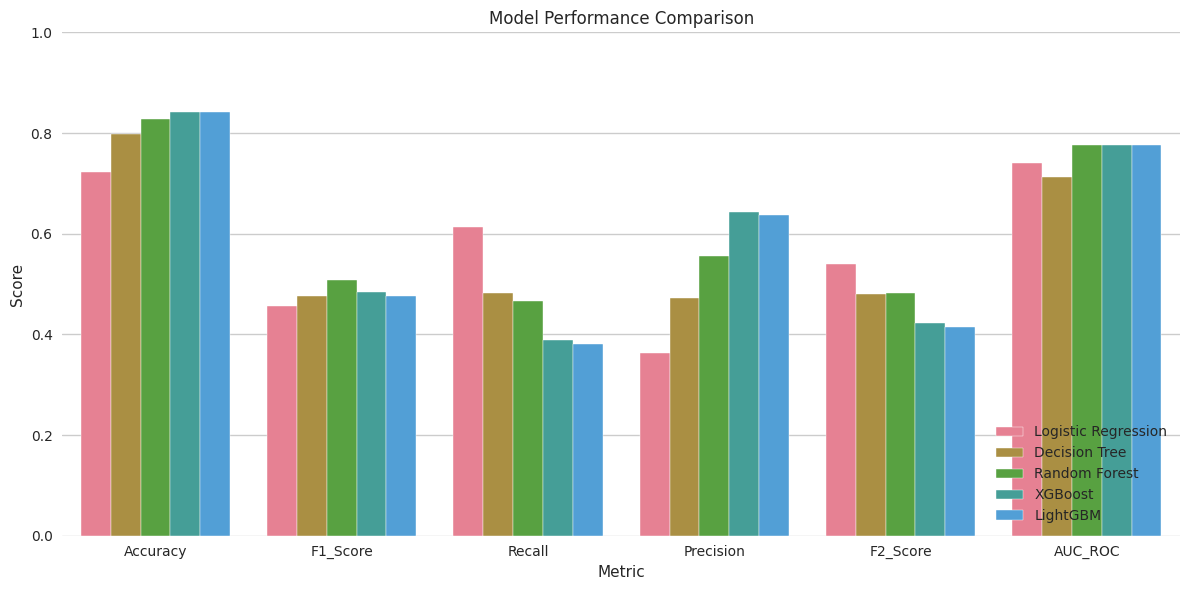

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of metrics to plot (only those present in results_df)
metrics_to_plot = ['Accuracy', 'F1_Score', 'Recall', 'Precision', 'F2_Score', 'AUC_ROC']
metrics_to_plot = [m for m in metrics_to_plot if m in results_df.columns]

# Prepare data for plotting
plot_df = results_df.melt(id_vars='Model', value_vars=metrics_to_plot,
                          var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Feature importance not available for Logistic Regression


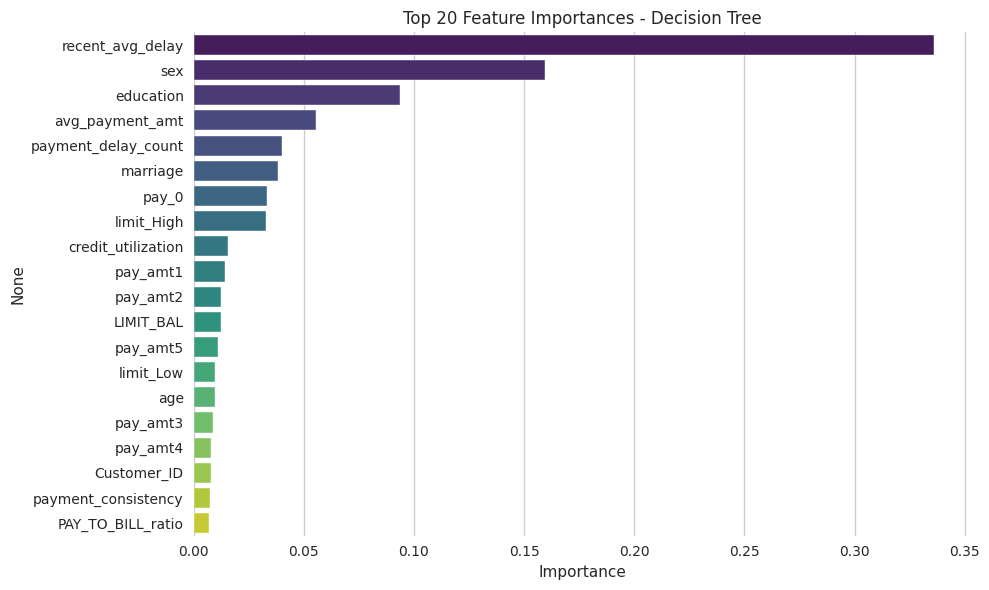

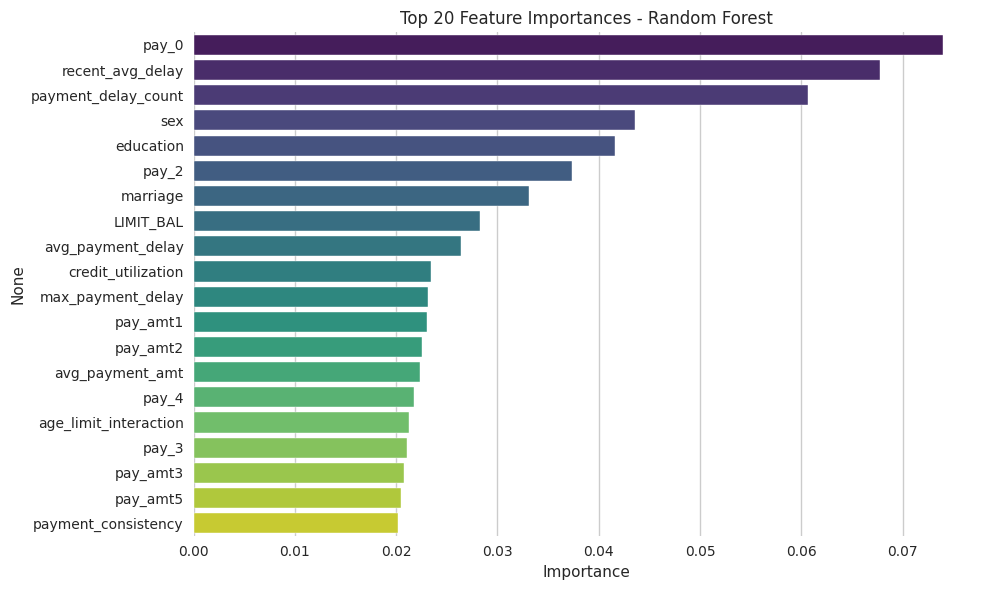

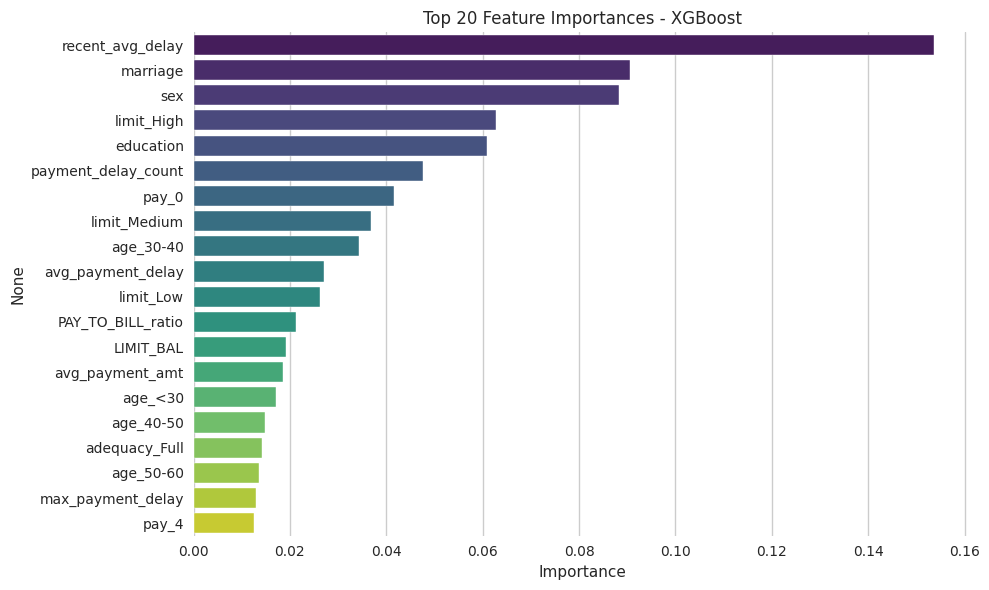

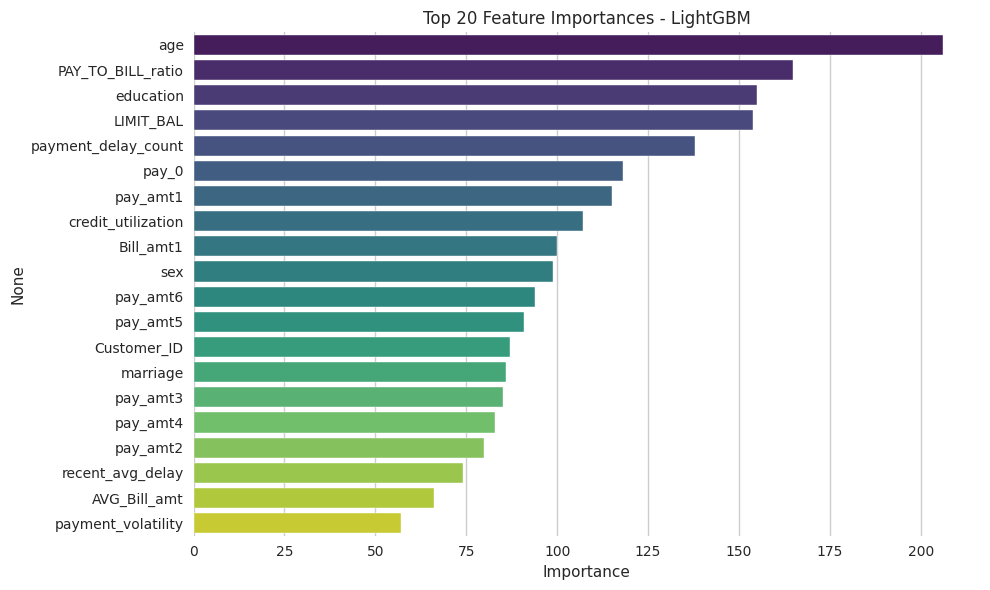

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_importance(model, X, model_name):
    if hasattr(model, 'feature_importances_'):
        fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)[:20]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=fi.values, y=fi.index, palette='viridis')
        plt.title(f'Top 20 Feature Importances - {model_name}')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature importance not available for {model_name}")

# Example: plot for all tree-based models
for model_name, model in trained_models.items():
    plot_feature_importance(model, X_train_balanced, model_name)


In [ ]:
# =====================================
# 8.HYPERPARAMETER TUNING FOR BEST MODEL
# =====================================

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
import numpy as np
import time

def custom_f2_scorer(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, zero_division=0)

# Parameter grids for RandomizedSearchCV (fast, covers most useful params)
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'min_child_samples': [10, 20],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5],
        'num_leaves': [31, 50, 70]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2', None]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000]
    }
}

# Pick best model name (from your previous selection logic)
if 'results_df' in locals() and len(results_df) > 0:
    best_model_name = results_df.loc[results_df['F2_Score'].idxmax(), 'Model']
else:
    best_model_name = 'XGBoost'

print(f"\nBest model based on F2 Score: {best_model_name}")

# Prepare base model
if best_model_name == 'XGBoost':
    import xgboost as xgb
    base_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)
elif best_model_name == 'LightGBM':
    import lightgbm as lgb
    base_model = lgb.LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1)
elif best_model_name == 'Random Forest':
    from sklearn.ensemble import RandomForestClassifier
    base_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
elif best_model_name == 'Decision Tree':
    from sklearn.tree import DecisionTreeClassifier
    base_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
elif best_model_name == 'Logistic Regression':
    from sklearn.linear_model import LogisticRegression
    base_model = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=-1)
else:
    base_model = trained_models.get(best_model_name)

# Ensure clean training data
if 'X_train_balanced_clean' not in locals():
    X_train_balanced_clean = X_train_balanced.copy()
    X_test_split_clean = X_test_split.copy()

# Use a sample for speed if large
sample_size = min(4000, len(X_train_balanced_clean))
if len(X_train_balanced_clean) > sample_size:
    print(f"Using sample of {sample_size} records for hyperparameter tuning (faster execution)")
    sample_indices = np.random.choice(len(X_train_balanced_clean), sample_size, replace=False)
    X_sample = X_train_balanced_clean.iloc[sample_indices]
    y_sample = y_train_balanced.iloc[sample_indices]
else:
    X_sample = X_train_balanced_clean
    y_sample = y_train_balanced

# RandomizedSearchCV
f2_scorer = make_scorer(custom_f2_scorer)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
params = param_grids.get(best_model_name, param_grids['XGBoost'])

print(f"\n--- RandomizedSearchCV for {best_model_name} ---")
start_time = time.time()
random_search = RandomizedSearchCV(
    base_model,
    params,
    n_iter=20,  # Fast, but covers enough ground
    cv=cv_strategy,
    scoring=f2_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
random_search.fit(X_sample, y_sample)
tune_time = time.time() - start_time

print(f"Best F2 Score: {random_search.best_score_:.4f}")
print(f"Best Parameters: {random_search.best_params_}")
print(f"RandomizedSearchCV time: {tune_time:.2f} seconds")

# Retrain best model on full data
final_best_model = random_search.best_estimator_
if len(X_train_balanced_clean) > sample_size:
    print("Retraining on full balanced data...")
    final_best_model.fit(X_train_balanced_clean, y_train_balanced)

# Evaluate on test set
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f2 = fbeta_score(y_test, y_pred, beta=2, zero_division=0)
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'F2_Score': f2
    }
    if y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
        results['AUC_ROC'] = auc
    return results

print(f"\n=== FINAL EVALUATION OF TUNED {best_model_name} ===")
tuned_results = evaluate_model(final_best_model, X_test_split_clean, y_test_split, f"Tuned {best_model_name}")
for metric, value in tuned_results.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

print("\n✓ Hyperparameter tuning and evaluation complete!")


## IT WILL TAKE SOME TIME 4-5 MINS



Best model based on F2 Score: Logistic Regression
Optimal threshold: 0.400
Optimal F2 score: 0.5726


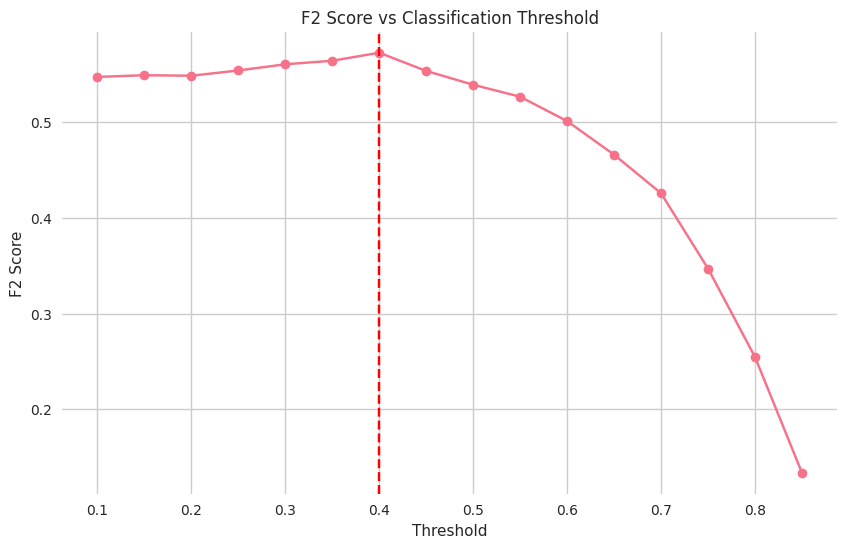

In [69]:
# =====================================
# 9. BEST MODEL SELECTION & THRESHOLD OPTIMIZATION
# =====================================

# Select best model based on F2 Score
best_model_name = results_df.loc[results_df['F2_Score'].idxmax(), 'Model']
best_model = trained_models[best_model_name]  # Get the actual model object

print(f"\nBest model based on F2 Score: {best_model_name}")

# =====================================
# 9. THRESHOLD OPTIMIZATION
# =====================================

# Get prediction probabilities from the best model
y_pred_proba = best_model.predict_proba(X_test_split_clean)[:, 1]

# Calculate F2 scores for different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
f2_scores = [fbeta_score(y_test_split, (y_pred_proba >= t).astype(int), beta=2) for t in thresholds]

# Find optimal threshold
optimal_idx = np.argmax(f2_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f2 = f2_scores[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Optimal F2 score: {optimal_f2:.4f}")

# Plot threshold vs F2 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f2_scores, marker='o')
plt.axvline(x=optimal_threshold, color='r', linestyle='--')
plt.title('F2 Score vs Classification Threshold')
plt.xlabel('Threshold')
plt.ylabel('F2 Score')
plt.grid(True)
plt.show()


In [70]:
print("Validation columns:", validation_df.columns.tolist())


Validation columns: ['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']


In [71]:
# =====================================
# 10. FINAL PREDICTIONS ON VALIDATION SET
# =====================================

print("\n=== GENERATING FINAL PREDICTIONS ===")

# 1. Get best model object (not just name)
best_model_name = results_df.loc[results_df['F2_Score'].idxmax(), 'Model']
best_model = trained_models[best_model_name]  # Get actual model from trained_models dict

# 2. Clean validation features (critical step!)
X_validation_clean = clean_feature_names(X_validation)

# 3. Make predictions with optimal threshold
validation_proba = best_model.predict_proba(X_validation_clean)[:, 1]
validation_predictions = (validation_proba >= optimal_threshold).astype(int)

# 4. Create submission file
submission_df = pd.DataFrame({
    'Customer': validation_df['Customer_ID'],
    'next_month_default': validation_predictions
})

# 5. Save with enrollment number
enrollment_number = "22112016"  # REPLACE THIS!
submission_filename = f"submission_{enrollment_number}.csv"
submission_df.to_csv(submission_filename, index=False)

print(f"Predictions saved to: {submission_filename}")
print(f"Submission shape: {submission_df.shape}")
print(f"Default predictions: {submission_df['next_month_default'].sum()}")
print(f"Default rate: {submission_df['next_month_default'].mean():.3f}")
print("\nFirst 5 predictions:")
print(submission_df.head())



=== GENERATING FINAL PREDICTIONS ===
Predictions saved to: submission_22112016.csv
Submission shape: (5016, 2)
Default predictions: 2791
Default rate: 0.556

First 5 predictions:
   Customer  next_month_default
0         1                   1
1         2                   0
2         3                   0
3         4                   1
4         5                   0


In [72]:
import os
os.listdir()
!ls
from google.colab import files
files.download(submission_filename)

sample_data		 train_dataset_final1.csv
submission_22112016.csv  validate_dataset_final.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== MODEL INTERPRETABILITY WITH SHAP ===


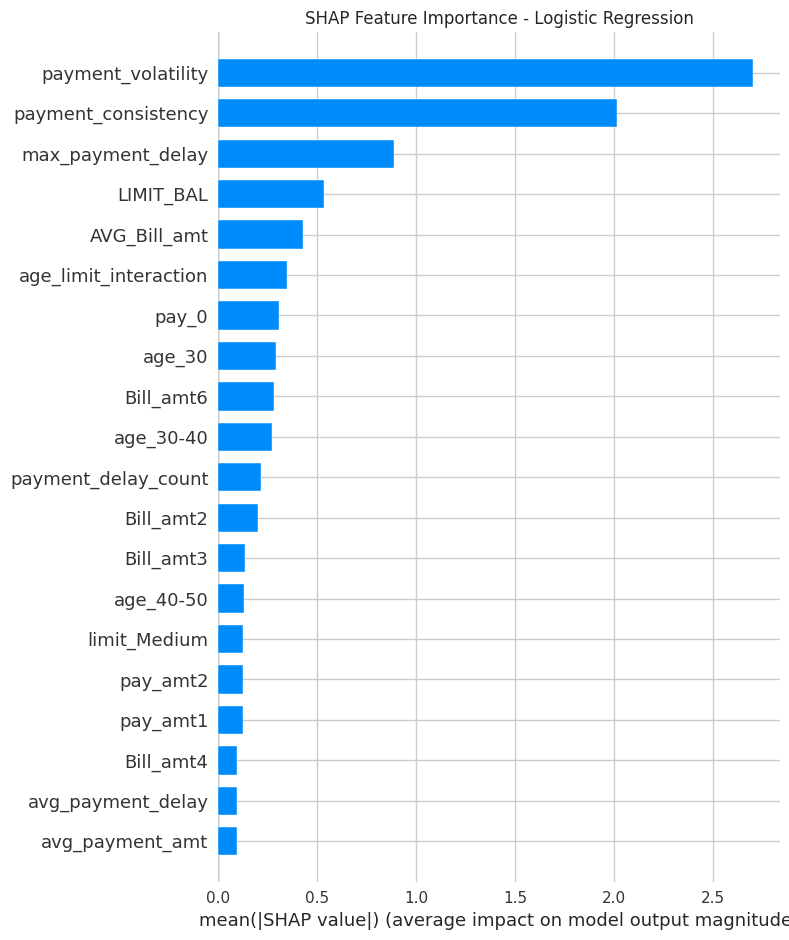

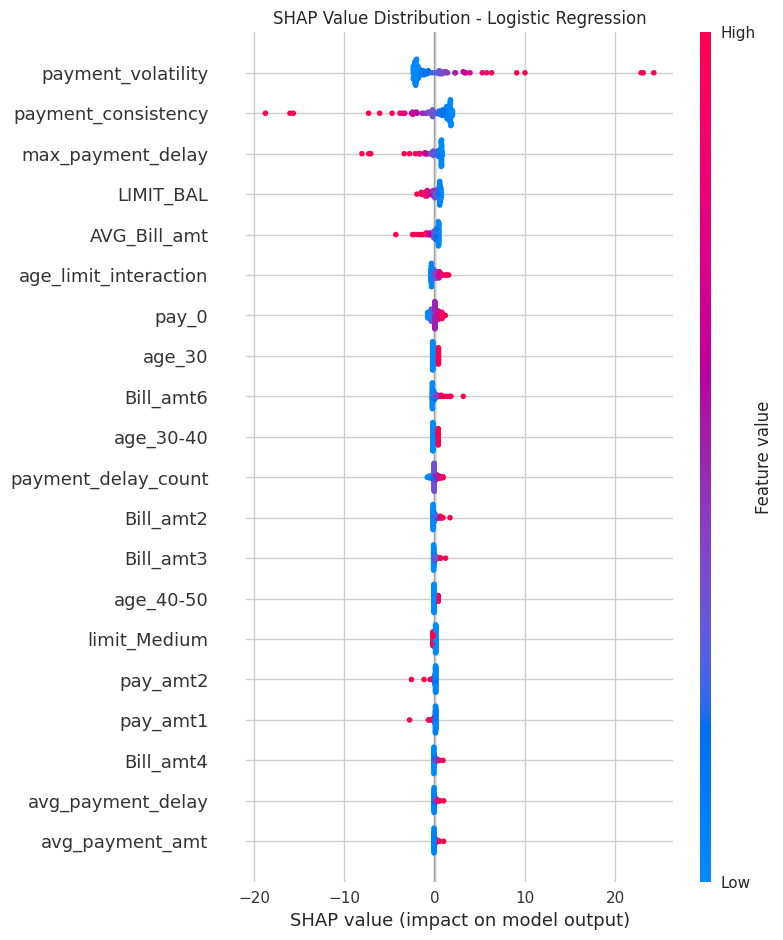

✓ SHAP analysis completed successfully.

PROJECT INSIGHTS AND SUMMARY

1. MODEL PERFORMANCE:
   - Best Model: Logistic Regression
   - Optimal Threshold: 0.400
   - F2 Score: 0.5726
   - This model prioritizes catching defaults (high recall) while maintaining reasonable precision

2. KEY RISK FACTORS:

3. BUSINESS RECOMMENDATIONS:
   - Monitor customers with high payment delays (pay_0, pay_2, etc.)
   - Focus on customers with low pay-to-bill ratios
   - Implement early warning systems for customers showing payment inconsistency
   - Consider credit limit adjustments based on utilization patterns

4. MODEL DEPLOYMENT CONSIDERATIONS:
   - Regular model retraining recommended (monthly/quarterly)
   - Monitor model performance with new data
   - Consider A/B testing for threshold optimization
   - Expected default rate in validation set: 55.6%

5. FINANCIAL IMPACT:
   - Total customers evaluated: 5,016
   - Predicted defaults: 2,791
   - Default rate: 55.6%

ANALYSIS COMPLETE

Files gener

In [74]:
# =====================================
# 11. MODEL INTERPRETABILITY (SHAP)
# =====================================

print("\n=== MODEL INTERPRETABILITY WITH SHAP ===")

import shap

try:
    # Use cleaned test features
    sample_size = min(100, len(X_test_split_clean))
    X_sample = X_test_split_clean.iloc[:sample_size]

    # Use the correct SHAP explainer for the model type
    if best_model_name in ['XGBoost', 'Random Forest', 'Decision Tree', 'LightGBM']:
        explainer = shap.Explainer(best_model, X_sample)
        shap_values = explainer(X_sample)
    elif best_model_name == 'Logistic Regression':
        explainer = shap.Explainer(best_model, X_sample)
        shap_values = explainer(X_sample)
    else:
        raise ValueError("SHAP analysis not supported for this model type.")

    # SHAP summary plot (feature importance bar)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

    # SHAP summary plot (detailed)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f'SHAP Value Distribution - {best_model_name}')
    plt.tight_layout()
    plt.show()

    print("✓ SHAP analysis completed successfully.")

except Exception as e:
    print(f"SHAP analysis failed: {str(e)}")
    print("Possible reasons:")
    print("- Model type not supported by SHAP.")
    print("- Feature names mismatch between training and explanation data.")
    print("- Memory issues with large datasets (try smaller sample size).")


# =====================================
# 12. PROJECT INSIGHTS AND SUMMARY
# =====================================

print("\n" + "="*50)
print("PROJECT INSIGHTS AND SUMMARY")
print("="*50)

print("\n1. MODEL PERFORMANCE:")
print(f"   - Best Model: {best_model_name}")
print(f"   - Optimal Threshold: {optimal_threshold:.3f}")
print(f"   - F2 Score: {optimal_f2:.4f}")
print(f"   - This model prioritizes catching defaults (high recall) while maintaining reasonable precision")

print("\n2. KEY RISK FACTORS:")
if 'feature_importance' in locals():
    top_5_features = feature_importance.head(5)['feature'].tolist()
    print("   Top 5 predictive features:")
    for i, feature in enumerate(top_5_features, 1):
        print(f"   {i}. {feature}")

print("\n3. BUSINESS RECOMMENDATIONS:")
print("   - Monitor customers with high payment delays (pay_0, pay_2, etc.)")
print("   - Focus on customers with low pay-to-bill ratios")
print("   - Implement early warning systems for customers showing payment inconsistency")
print("   - Consider credit limit adjustments based on utilization patterns")

print("\n4. MODEL DEPLOYMENT CONSIDERATIONS:")
print("   - Regular model retraining recommended (monthly/quarterly)")
print("   - Monitor model performance with new data")
print("   - Consider A/B testing for threshold optimization")
print(f"   - Expected default rate in validation set: {submission_df['next_month_default'].mean():.1%}")

print("\n5. FINANCIAL IMPACT:")
default_rate = submission_df['next_month_default'].mean()
total_customers = len(submission_df)
print(f"   - Total customers evaluated: {total_customers:,}")
print(f"   - Predicted defaults: {submission_df['next_month_default'].sum():,}")
print(f"   - Default rate: {default_rate:.1%}")

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)

print(f"\nFiles generated:")
print(f"1. {submission_filename} - Final predictions")
print(f"2. All visualizations and analysis above")
